Schwarz et al.(1996): "Quantitative analysis of lateral force microscopy experiments"

In [1]:
import nanosurf as nsf
from nanosurf.lib.spm.scanhead.drive_afm import DriveMotorID
from nanosurf.lib.spm.scanhead.studio_motor_control import StudioMotorControl

import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# In case Studio should be used connect to Studio
print("Connecting to Nanosurf controller")
ok = False
studio = nsf.Studio()
if studio.connect():
    ok = True
    print(f"Available sessions: {studio.main.session.list()}")
    print(f"Connected with session '{studio.session_id}'")
else:
    print("Error: Could not connect to controller. Check if software is started")

In [ ]:
# Delete Studio session
del studio
print("Disconnected from Nanosurf controller")

In [ ]:
#setup shortcuts for workflows and signals in Studio
drive_motors = DriveMotorID()
motor_control = StudioMotorControl()

wf_laser_align = studio.spm.workflow.laser_align
wf_frequency_sweep = studio.spm.workflow.frequency_sweep
lu_deflection_in = studio.spm.lu.analog_hi_res_in.deflection
lu_lateral_in = studio.spm.lu.analog_hi_res_in.lateral
lu_sum_in = studio.spm.lu.analog_hi_res_in.detector_sum
lu_signal_analyzer = studio.spm.lu.signal_analyzer.inst1
core_laser = studio.spm.core.laser_align_drive_impl

In [4]:
# Start a Laser Auto Alignment first
wf_laser_align.start_auto_align()

In [ ]:
# Test detector motor movement
read_out_x = 0.0
read_out_y = 0.00001
pte_x = 0.0
pte_y = 0.0
target_positions = [read_out_x, read_out_y]
motor_control.do_move_relative([drive_motors.PHOTODIODE_X, drive_motors.PHOTODIODE_Y], target_positions)

In [ ]:
# Read detector signals
deflection_value = lu_deflection_in.attribute.current_input_value.value
lateral_value = lu_lateral_in.attribute.current_input_value.value
sum_value = lu_sum_in.attribute.current_input_value.value
print(deflection_value)
print(lateral_value)
print(sum_value)

In [5]:
### variable and parameter initialization ###
deflection_arr = []
lateral_arr = []
sum_arr = []
position_arr_x= []
position_arr_y= []
deflection_value = 0
lateral_value = 0

In [7]:
### lateral calibration settings ###
# calibration settings
step_size = 0.000001
calibration_range = 2.5 # [V], set to 5 for full range
calibration_factor_A = 0

# cantilever properties
canti_youngs_modulus = 130E9 # [N/m^2] Si
canti_torsional_modulus = 80E9 # [N/m^2]
canti_length = 225 # [um]
canti_width = 28 # [um]
canti_thickness = 3 # [um]
canti_tip_length = 17 # [um]
canti_normal_deflection_sensitivity = 160.06 # [nm/V]
canti_normal_spring_constant = 2.85 # [N/m]

# unit conversion
canti_length = canti_length*1E-6 # [m]
canti_width = canti_width*1E-6 # [m]
canti_thickness = canti_thickness*1E-6 # [m]
canti_tip_length = canti_tip_length*1E-6 # [m]
canti_S_ver = 1/(canti_normal_deflection_sensitivity*1E-9) # [V/m]
canti_c_ver = (2*canti_length*canti_S_ver)/3

In [ ]:
### Start data acquisition for lateral calibration ###

minimal_sum_value = 0.23
attr_detector_auto_adjustment_status = studio.spm.lu.sensor_control.instance.attribute.detector_auto_adjustment_status

# Center Detector
sum_value = lu_sum_in.attribute.current_input_value.value
if sum_value > minimal_sum_value:
   core_laser.center_detector()

while attr_detector_auto_adjustment_status.value == attr_detector_auto_adjustment_status.ValueEnum.running:
    time.sleep(0.3)
    print('Centering detector...')

# Move to lower deflection limit
while (deflection_value >= -1*calibration_range):
    motor_control.do_move_relative([drive_motors.PHOTODIODE_Y], -0.00001)
    time.sleep(0.1)
    deflection_value = lu_deflection_in.attribute.current_input_value.value
    print('Moving to lower limit Y...') 

# Move along y axis and acquire deflection values until it hits the end of the detector
i = 0
while (deflection_value <= calibration_range):
    deflection_value = lu_deflection_in.attribute.current_input_value.value
    deflection_arr.append(deflection_value)
    position_value = i*step_size
    position_arr_y.append(position_value)
    motor_control.do_move_relative([drive_motors.PHOTODIODE_Y], step_size)
    i=i+1
    time.sleep(0.3)
    print('Measuring vertical...')

# Center Detector again
sum_value = lu_sum_in.attribute.current_input_value.value
if sum_value > minimal_sum_value:
   core_laser.center_detector()

while attr_detector_auto_adjustment_status.value == attr_detector_auto_adjustment_status.ValueEnum.running:
    time.sleep(0.3)
    print('Centering detector...')

# Move to lower lateral limit
while (lateral_value >= -1*calibration_range):
    motor_control.do_move_relative([drive_motors.PHOTODIODE_X], -0.00001)
    time.sleep(0.3)
    lateral_value = lu_lateral_in.attribute.current_input_value.value
    print('Moving to lower limit X...')

# Move along x axis and acquire lateral values until it hits the end of the detector
i = 0
while (lateral_value <= calibration_range):
    lateral_value = lu_lateral_in.attribute.current_input_value.value
    lateral_arr.append(lateral_value)
    position_value = i*step_size
    position_arr_x.append(position_value)
    motor_control.do_move_relative([drive_motors.PHOTODIODE_X], step_size)
    i=i+1
    time.sleep(0.3)
    print('Measuring horizontal...')

# Center Detector finally
sum_value = lu_sum_in.attribute.current_input_value.value
if sum_value > minimal_sum_value:
   core_laser.center_detector()

while attr_detector_auto_adjustment_status.value == attr_detector_auto_adjustment_status.ValueEnum.running:
    time.sleep(0.1)
    print('Centering detector...')

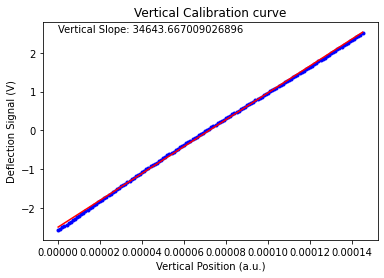

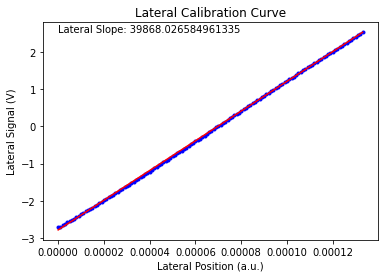

Vertical slope m_ver 3.46e+04
Lateral slope m_lat = 3.99e+04
Lateral angular sensitivity c_lat = 1.08e+03 V/rad
Lateral angular sensitivity 1/c_lat = 0.000927 rad/V
Calibration Factor A = 71 N/V multiply with U_lateral to get F_lateral (N)


In [10]:
### Data analysis ###
# Plot vertical curve
plt.title('Vertical Calibration curve')
plt.xlabel('Vertical Position (a.u.)')
plt.ylabel('Deflection Signal (V)')

# Create a polynomial function from the coefficients
m_ver, intercept_ver = np.polyfit(position_arr_y[0:len(deflection_arr)], deflection_arr, 1)
poly = np.poly1d([m_ver, intercept_ver])

# Generate x values for the plot
x = np.linspace(np.array(position_arr_y).min(), np.array(position_arr_y).max(), 100)

# Calculate y values for the plot
y = poly(x)

# create plot
plt.text(x=x.min(),y=y.max(),s=f'Vertical Slope: {m_ver}')
plt.plot(position_arr_y[0:len(deflection_arr)], deflection_arr, 'b.', x, y, 'r-')
plt.show()

# Plot lateral curve
plt.title('Lateral Calibration Curve')
plt.xlabel('Lateral Position (a.u.)')
plt.ylabel('Lateral Signal (V)')
# Create a polynomial function from the coefficients
m_lat, intercept_lat = np.polyfit(position_arr_x[0:len(lateral_arr)], lateral_arr, 1)
poly = np.poly1d([m_lat, intercept_lat])

# Generate x values for the plot
x = np.linspace(np.array(position_arr_x).min(), np.array(position_arr_x).max(), 100)

# Calculate y values for the plot
y = poly(x)

# create second plot
plt.text(x=x.min(),y=y.max(),s=f'Lateral Slope: {m_lat}')
plt.plot(position_arr_x[0:len(lateral_arr)], lateral_arr, 'b.', x, y, 'r-')
plt.show()

# Calculate calibration factor A [V/N] from obtained data
canti_m = m_lat/m_ver
calibration_factor_A = (canti_torsional_modulus*canti_width**3)/(4*canti_length**2*canti_tip_length*canti_m*canti_S_ver)
canti_c_lat = canti_m*canti_c_ver
print(f'Vertical slope m_ver {m_ver:.3g}')
print(f'Lateral slope m_lat = {m_lat:.3g}')
print(f'Lateral angular sensitivity c_lat = {canti_c_lat:.3g} V/rad')
print(f'Lateral angular sensitivity 1/c_lat = {1/canti_c_lat:.3g} rad/V')
print(f'Calibration Factor A = {calibration_factor_A:.3g} N/V multiply with U_lateral to get F_lateral (N)')